In [14]:
import sys
sys.path.append("..")

import torch
from torch.utils.data import DataLoader
from utils.utils import *
import argparse
import json
from utils.datasets import ScutHeadDataset, pad_to_square
from models import Darknet
from tqdm import tqdm
from utils.plot import draw_prediction
import torch.nn.functional as F
import matplotlib.pyplot as plt

import cv2
import os

from utils.plot import draw_tracking_state
from utils.tracking import TrackingState, Tracklet
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
model_config = '../config/models/yolov3.cfg'

device = torch.device("cuda")
model = Darknet(model_config).to(device).eval()

In [3]:
# model_checkpoint = '../output/3exp__b_32_grad_1__lr_0.0001__frozen__/checkpoints/yolov3_epoch_9.pth'
exp_name = "exp__b_16_grad_4__lr_1,0e-04__aug__frozen__ (1)"
model_checkpoint = f'../output/{exp_name}/checkpoints/yolov3_epoch_19.pth'

model.load_state_dict(torch.load(model_checkpoint))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
darknet_weights = 'C:/Users/admin/Google Drive/Models/yolov3.weights'
model.load_darknet_weights(darknet_weights)

In [17]:
line1 = ((850,500), (1700,1100))
line2 = ((1000,550), (1900,1000))

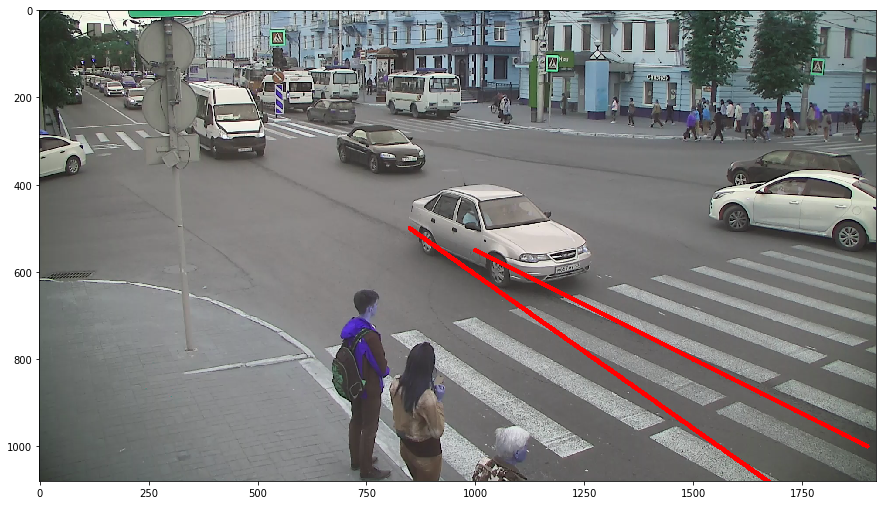

In [18]:
video_file = 'C:/Users/admin/Google Drive/Datasets/Видео БГ/016 Кирова - Рылеева_25_05_2019 12.05.00.mcm'

video_reader = cv2.VideoCapture(video_file)
video_reader.set(cv2.CAP_PROP_POS_MSEC, 0)

ret, image = video_reader.read()
image = cv2.line(image, (850,500), (1700,1100), color=255, thickness=10)
image = cv2.line(image, (1000,550), (1900,1000), color=255, thickness=10)
plt.figure(figsize = (15,15))
plt.imshow(image)

In [19]:
def get_bbox_center(bbox):
    "x1, y1, x2, y2"
    return (int(bbox[2]+bbox[0])//2, int(bbox[3]+bbox[1])//2)


def get_track_line(tracklet):
    return get_bbox_center(tracklet.bboxes[0]), get_bbox_center(tracklet.bboxes[-1])

# https://stackoverflow.com/a/9997374
# def ccw(A,B,C):
#     return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
    

In [23]:
start_time=700
frames_num=2000
fps=25.0
conf_thres=0.4
nms_thres=0.4
trail_size=10
print_text=False

video_out = video_file[:-4] + f'_counter_conf_{conf_thres}_nms_{nms_thres}' + '.mp4'
video_reader = cv2.VideoCapture(video_file)

# FIXME:
for _ in range(start_time):
    _, _ = video_reader.read()

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                       cv2.VideoWriter_fourcc(*'MPEG'), 
                       25.0, 
                       (frame_w, frame_h))

boxes_list = []

tracking_state = TrackingState(
    sigma_h=0.5,
    sigma_iou=0.3,
    min_length=5,
    max_lost_time=10,
)

line1_intersects, line2_intersects = 0, 0

for i in tqdm(range(frames_num)):
    _, image = video_reader.read()

    pred_bboxes = model.predict(image, conf_thres=conf_thres, nms_thres=nms_thres)
    # filter out non-person detections
    pred_bboxes = pred_bboxes[pred_bboxes[:, 6] == 0]
    tracking_state.update_tracks(np.array(pred_bboxes))
    image = draw_tracking_state(image, tracking_state, trail_size=trail_size, print_text=print_text)
    
    image = cv2.line(image, line1[0], line1[1], color=255, thickness=10)
    image = cv2.line(image, line2[0], line2[1], color=255, thickness=10)
    
    for track in tracking_state.active_tracks:
        line = (get_bbox_center(track.bboxes[-2]), get_bbox_center(track.bboxes[-1]))
        image = cv2.line(image, line[0], line[1], color=(255,0,0), thickness=5)
        line1_intersects += intersect(line[0], line[1], line1[0], line1[1])
        line2_intersects += intersect(line[0], line[1], line2[0], line2[1])
        # print(line)
    
    cv2.putText(image, str(line1_intersects), line1[0], cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2)
    cv2.putText(image, str(line2_intersects), line2[0], cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2)

    video_writer.write(np.uint8(image))

video_writer.release()
video_reader.release()

100%|██████████████████████████████████████| 2000/2000 [18:44<00:00,  1.57it/s]


In [66]:
for track in tracking_state.active_tracks:
    line = (get_bbox_center(track.bboxes[-3]), get_bbox_center(track.bboxes[-1]))
    print(line)

((434, 107), (434, 107))
((1106, 207), (1105, 210))
((1700, 179), (1691, 181))
((539, 149), (539, 149))


In [10]:
pt1, pt2 = (850,500), (1700,1100)

In [48]:
tracking_state = track_video(video_file, start_time=0, frames_num=5000)

100%|██████████████████████████████████████| 5000/5000 [43:05<00:00,  2.15it/s]


In [18]:
np.stack(tracking_state.finished_tracks[0].bboxes)

array([[7.1141541e+02, 6.2875439e+02, 7.7655164e+02, 7.0475153e+02,
        8.5342622e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1302045e+02, 6.2869745e+02, 7.7747095e+02, 7.0416516e+02,
        8.3831447e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1297156e+02, 6.2873828e+02, 7.7743750e+02, 7.0420441e+02,
        8.3884233e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1467871e+02, 6.2933954e+02, 7.7891437e+02, 7.0416187e+02,
        8.1165481e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1478070e+02, 6.2928302e+02, 7.7893860e+02, 7.0414258e+02,
        8.1395483e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1375360e+02, 6.3006055e+02, 7.7932758e+02, 7.0384045e+02,
        7.5273710e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1386444e+02, 6.3014520e+02, 7.7935138e+02, 7.0357153e+02,
        7.4906433e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1186639e+02, 6.2644647e+02, 7.8175793e+02, 7.0752112e+02,
        6.6735882e-01, 1.0000000e+00, 0.0000000e+00],
       [7.1175128e+02, 6

In [21]:
track = [bbox[2:4] for bbox in tracking_state.finished_tracks[0].bboxes]

In [28]:
tuple(track[0])

(776.55164, 704.7515)

In [58]:
for track in tracking_state.finished_tracks:
    
    track_points = [bbox[2:4] for bbox in track.bboxes]

    for pt1, pt2 in zip(track_points[:-1], track_points[1:]):
        image = cv2.line(image, tuple(pt1), tuple(pt2), color=(255,0,255), thickness=10)

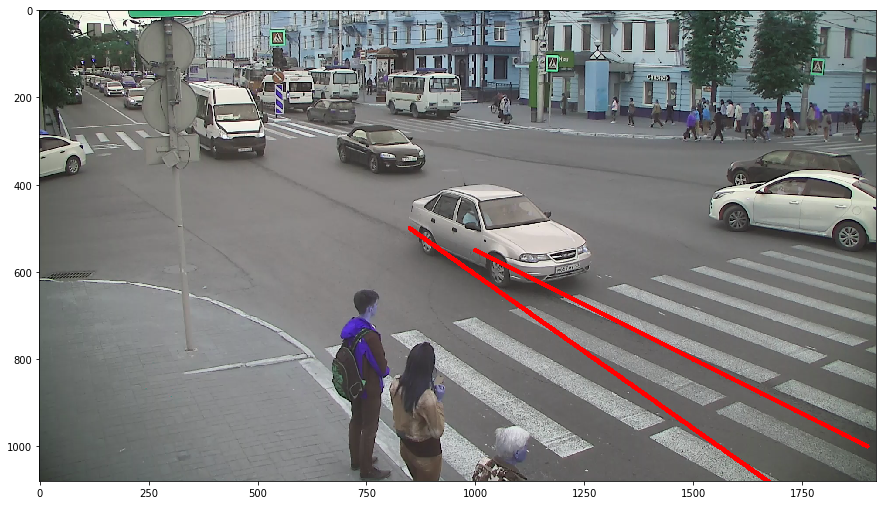

In [25]:
plt.figure(figsize = (15,15))
plt.imshow(image)

In [50]:
import pickle

with open("tracking_state", "wb") as tracking_state_file:
    pickle.dump(tracking_state, tracking_state_file)

In [3]:
import pickle

with open('tracking_state', 'rb') as f:
    tracking_state = pickle.load(f)

In [63]:
def get_bbox_center(bbox):
    "x1, y1, x2, y2"
    return (int(bbox[2]+bbox[0])//2, int(bbox[3]+bbox[1])//2)


def get_track_line(tracklet):
    return get_bbox_center(tracklet.bboxes[0]), get_bbox_center(tracklet.bboxes[-1])

# https://stackoverflow.com/a/9997374
# def ccw(A,B,C):
#     return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
    

In [14]:
track_line = get_track_line(tracking_state.finished_tracks[0])

In [ ]:
def check_intersections(state, line):
    i = 0
    for track in tracking_state.finished_tracks:
        track_line = get_track_line(track)
        i += intersect(track_line[0], track_line[1], line1[0], line1[1])
    
print(i)

In [47]:
i = 0
for track in tracking_state.finished_tracks:
    track_line = get_track_line(track)
    i += intersect(track_line[0], track_line[1], line1[0], line1[1])
    
print(i)

13


In [48]:
i = 0
for track in tracking_state.finished_tracks:
    track_line = get_track_line(track)
    i += intersect(track_line[0], track_line[1], line2[0], line2[1])
    
print(i)

6


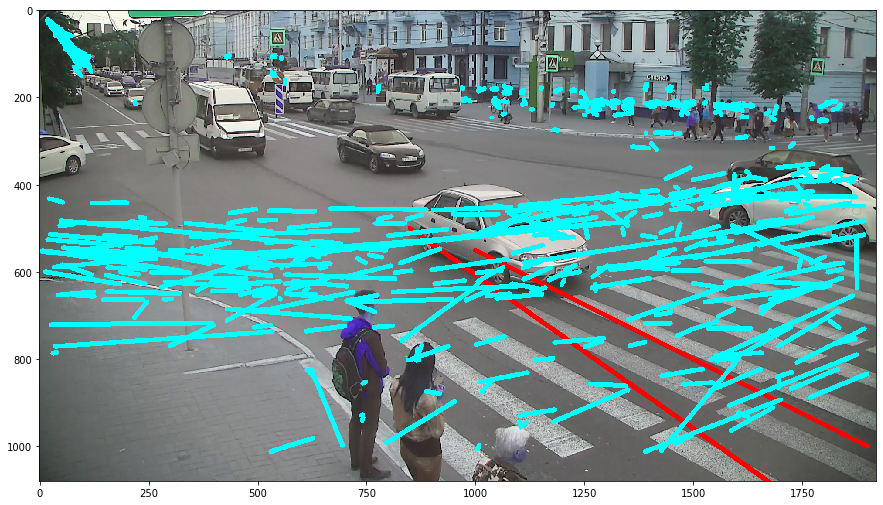

In [45]:
plt.figure(figsize = (15,15))
plt.imshow(image)

In [23]:
i

0